# Домашнее задание 4: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

## Часть 1: Основы построения решающего дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [14]:
print(-(0.8*np.log(0.8) + 0.2*np.log(0.2)))

0.5004024235381879


Примерно 0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [15]:
print(0.8*0.2 + 0.2*0.8)

0.32000000000000006


python шизит немного, ответ 0.32 (и округленный и без округления), вычитать ничего не надо, т.к. правые и левые поддеревья состоят из одного класса

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

Вообще немного некорректный вопрос, т.к. предсказание необязательно может быть средним арифметическим, но я буду считать, что предсказание такое

In [16]:
print(np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]).mean())

40.6


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [17]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это не всегда самый оптимальный способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. 

В качестве подсказок реализации можете пользоваться кодом из [бонусной части семинара по решающим деревьям](https://github.com/Murcha1990/ML_econom_2022-2023/blob/main/Семинары/Семинар%208/Seminar8_2022.ipynb).

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [42]:
def find_best_split(feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    
    в случае регрессии возвращаем не Джини, а дисперсию
    """
    if task == "classification":
        H = lambda x: (1 - ps(x)) @ ps(x).T 
    elif task == "regression":
        H = np.std
    def impurity(H, features, target, task, t):
      if task == "real":
        R_l = target[features < t]
        R_r = target[features >= t]
      else:
        R_l = target[features == t]
        R_r = target[features != t]
      return H(target) - len(R_l)/len(target)*H(R_l) - len(R_r)/len(target)*H(R_r)
  
    thresholds = (np.unique(feature_vector)[1:] + np.unique(feature_vector)[:-1])/2
    impurity_vect = np.vectorize(lambda t: impurity(H, feature_vector, target_vector, feature_type, t))
    gini = impurity_vect(thresholds)
    threshold_best = thresholds[np.argmax(gini)]
    gini_best = np.max(gini)

    return thresholds, gini, threshold_best, gini_best
    


Эту функцию можно протестировать на датасете `California` из `sklearn`.

In [43]:
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
X = pd.DataFrame(data=california["data"], columns=california["feature_names"])
y = california["target"]
print(X.head())

print(california["DESCR"])

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     av

In [44]:
thresholds, variances, threshold_best, variance_best = find_best_split(
    X["MedInc"].to_numpy(), 
    y, 
    task="regression",
    feature_type="real"
)

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

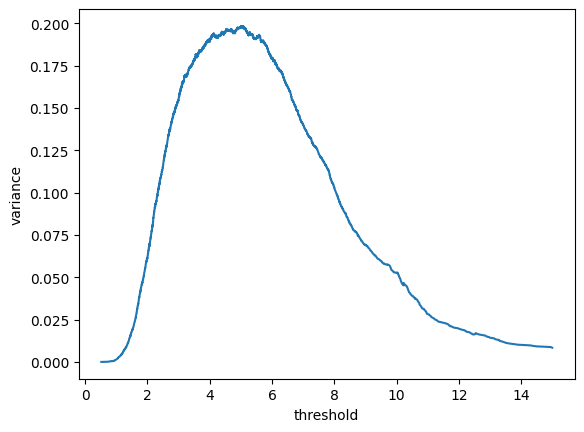

In [45]:
plt.plot(thresholds, variances)
plt.xlabel("threshold")
plt.ylabel("variance")
plt.show()

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [46]:
class DecisionTree:
    
    def __init__(self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector < threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold_best)
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
        else:
            if "threshold" in node:
                if x[node["feature_split"]] < node["threshold"]:
                    return _predict_node(self, x, node["left_child"])
                else:
                    return _predict_node(self, x, node["right_child"])
            else:
                if x[node["feature_split"]] == node["category_split"]:
                    return _predict_node(self, x, node["left_child"])
                else:
                    return _predict_node(self, x, node["right_child"])
        pass

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [51]:
#data = pd.read_excel('Data_User_Modeling_Dataset_Hamdi Tolga KAHRAMAN.xls')
#data
data = pd.read_csv('students.csv')
data

,Unnamed: 0,STG,SCG,STR,LPR,PEG,UNS
0,0,0.00,0.00,0.00,0.00,0.00,0
1,1,0.08,0.08,0.10,0.24,0.90,1
2,2,0.06,0.06,0.05,0.25,0.33,0
3,3,0.10,0.10,0.15,0.65,0.30,1
4,4,0.08,0.08,0.08,0.98,0.24,0
...,...,...,...,...,...,...,...
253,253,0.61,0.78,0.69,0.92,0.58,1
254,254,0.78,0.61,0.71,0.19,0.60,1
255,255,0.54,0.82,0.71,0.29,0.77,1
256,256,0.50,0.75,0.81,0.61,0.26,1


не успел нормально сделать это и след. задание (но бэггинг и дальше - делал)

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [58]:
from sklearn import preprocessing

data = pd.read_csv('agaricus-lepiota.data')
for i in data.columns:
  data[i] = preprocessing.LabelEncoder().fit(data[i]).transform(data[i])
data

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,0,3,2,4,0,5,0,0,0,11,...,2,5,5,0,1,1,4,0,1,2
8119,0,5,2,4,0,5,0,0,0,11,...,2,5,5,0,0,1,4,0,4,2
8120,0,2,2,4,0,5,0,0,0,5,...,2,5,5,0,1,1,4,0,1,2
8121,1,3,3,4,0,8,1,0,1,0,...,1,7,7,0,2,1,0,7,4,2


In [83]:
y = data['p']
#y

In [88]:
data.columns

Index(['p', 'x', 's', 'n', 't', 'p.1', 'f', 'c', 'n.1', 'k', 'e', 'e.1', 's.1',
       's.2', 'w', 'w.1', 'p.2', 'w.2', 'o', 'p.3', 'k.1', 's.3', 'u'],
      dtype='object')

In [96]:
X = data[['x', 's', 'n', 't', 'p.1', 'f', 'c', 'n.1', 'k', 'e', 'e.1', 's.1',
       's.2', 'w', 'w.1', 'p.2', 'w.2', 'o', 'p.3', 'k.1', 's.3', 'u']]
X = data.iloc[:, data.columns != 'p']
#X

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
dtr = DecisionTree(np.array(['categorical' for i in range(X.shape[1])]))
dtr.fit(X_train, y_train)
print(accuracy_score(dtr.predict(X_test), y_test))

KeyError: ignored

не нашел ошибку :(

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [25]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [26]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

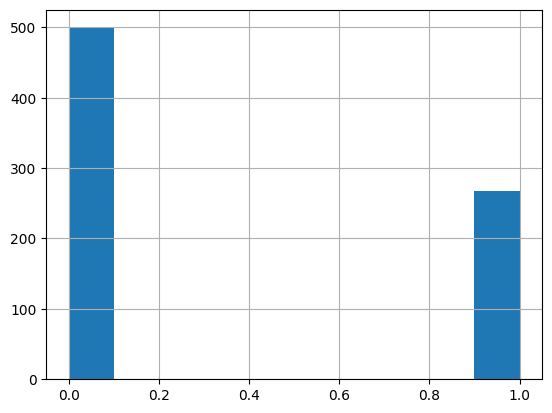

In [27]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [28]:
X = data.drop(columns = 'Outcome')
y = data['Outcome']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [29]:
from sklearn.metrics import f1_score

max_depth = [_ for _ in range(1,11)]
#print(max_depth)
min_samples_leaf = [_ for _ in range(1,21)]
d = dict()
for i in range(0,len(max_depth)):
    for j in range(0,len(min_samples_leaf)):
        clf = DecisionTreeClassifier(max_depth = max_depth[i], min_samples_leaf = min_samples_leaf[j])
        clf.fit(X_train, y_train)
        d[f'{max_depth[i]}, {min_samples_leaf[j]}'] = f1_score(y_val, clf.predict(X_val))

for key,value in d.items():
  print(key, ':', value)

1, 1 : 0.5384615384615384
1, 2 : 0.5384615384615384
1, 3 : 0.5384615384615384
1, 4 : 0.5384615384615384
1, 5 : 0.5384615384615384
1, 6 : 0.5384615384615384
1, 7 : 0.5384615384615384
1, 8 : 0.5384615384615384
1, 9 : 0.5384615384615384
1, 10 : 0.5384615384615384
1, 11 : 0.5384615384615384
1, 12 : 0.5384615384615384
1, 13 : 0.5384615384615384
1, 14 : 0.5384615384615384
1, 15 : 0.5384615384615384
1, 16 : 0.5384615384615384
1, 17 : 0.5384615384615384
1, 18 : 0.5384615384615384
1, 19 : 0.5384615384615384
1, 20 : 0.5384615384615384
2, 1 : 0.5581395348837209
2, 2 : 0.5581395348837209
2, 3 : 0.5581395348837209
2, 4 : 0.5581395348837209
2, 5 : 0.5581395348837209
2, 6 : 0.5581395348837209
2, 7 : 0.5581395348837209
2, 8 : 0.5581395348837209
2, 9 : 0.5581395348837209
2, 10 : 0.5581395348837209
2, 11 : 0.5581395348837209
2, 12 : 0.5581395348837209
2, 13 : 0.5581395348837209
2, 14 : 0.5581395348837209
2, 15 : 0.5581395348837209
2, 16 : 0.5581395348837209
2, 17 : 0.5581395348837209
2, 18 : 0.558139534

In [30]:
print(max(d.values()))

0.7321428571428573


Лучший результат -  6, 13 (лень писать поиск по словарю)
(а еще 6, 14 - но выберу только один)

In [32]:
clf = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 13)
clf.fit(X_train_full, y_train_full)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=13)

In [33]:
print('accuracy:', accuracy_score(y_test, clf.predict(X_test)))
print('precision:', precision_score(y_test, clf.predict(X_test)))
print('recall:', recall_score(y_test, clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, clf.predict(X_test)))

accuracy: 0.70995670995671
precision: 0.5526315789473685
recall: 0.56
ROC-AUC: 0.671025641025641


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [34]:
clf = BaggingClassifier(n_estimators = 50)
clf.fit(X_train, y_train)
print('accuracy:', accuracy_score(y_test, clf.predict(X_test)))
print('precision:', precision_score(y_test, clf.predict(X_test)))
print('recall:', recall_score(y_test, clf.predict(X_test)))
print('ROC-AUC:', roc_auc_score(y_test, clf.predict(X_test)))

accuracy: 0.7965367965367965
precision: 0.7258064516129032
recall: 0.6
ROC-AUC: 0.7455128205128205


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [35]:
from sklearn.model_selection import cross_val_score
max_depth = [_ for _ in range(1,11)]
min_samples_leaf = [_ for _ in range(1,21)]

best_params = []
best_f1 = 0
for i in range(0,len(max_depth)):
    for j in range(0,len(min_samples_leaf)):
        f1_cross = cross_val_score(RandomForestClassifier(n_estimators = 50, max_depth = max_depth[i], min_samples_leaf = min_samples_leaf[j]),
                              X_train_full, y_train_full, cv = 5)
        #print(f1_cross)
        if np.mean(f1_cross) > best_f1:
          best_f1 = np.mean(f1_cross)
          best_params = [max_depth[i], min_samples_leaf[j]]

In [36]:
best_params

[8, 9]

Жесть, он обучался 2 минуты (я умер, пока дебажил)



In [37]:
rf = RandomForestClassifier(n_estimators = 50, max_depth = 8, min_samples_leaf = 9)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('accuracy:', accuracy_score(y_test, y_pred))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred))

accuracy: 0.7878787878787878
precision: 0.7321428571428571
recall: 0.5466666666666666
ROC-AUC: 0.7252564102564103


**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

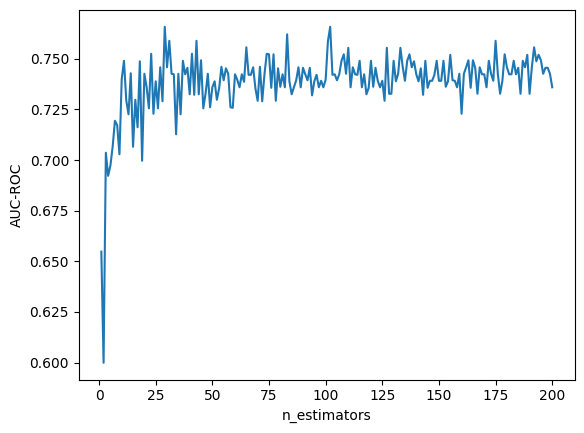

In [38]:
x = [_ for _ in range(1,201)]
y = []
for i in range(1, 201):
    fclf = RandomForestClassifier(max_depth = 10, min_samples_leaf = 3, n_estimators = i)
    fclf.fit(X_train_full, y_train_full)
    y.append(roc_auc_score(y_test, fclf.predict(X_test)))
plt.plot(x, y)
plt.xlabel("n_estimators")
plt.ylabel("AUC-ROC")
plt.show()

50 деревьев - не самый лучший вариант, при маленьком числе у нас рок-аук плохой, при большом уже все не так эффективно, лучше всего в районе 30 или 100 деревьев

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

<BarContainer object of 8 artists>

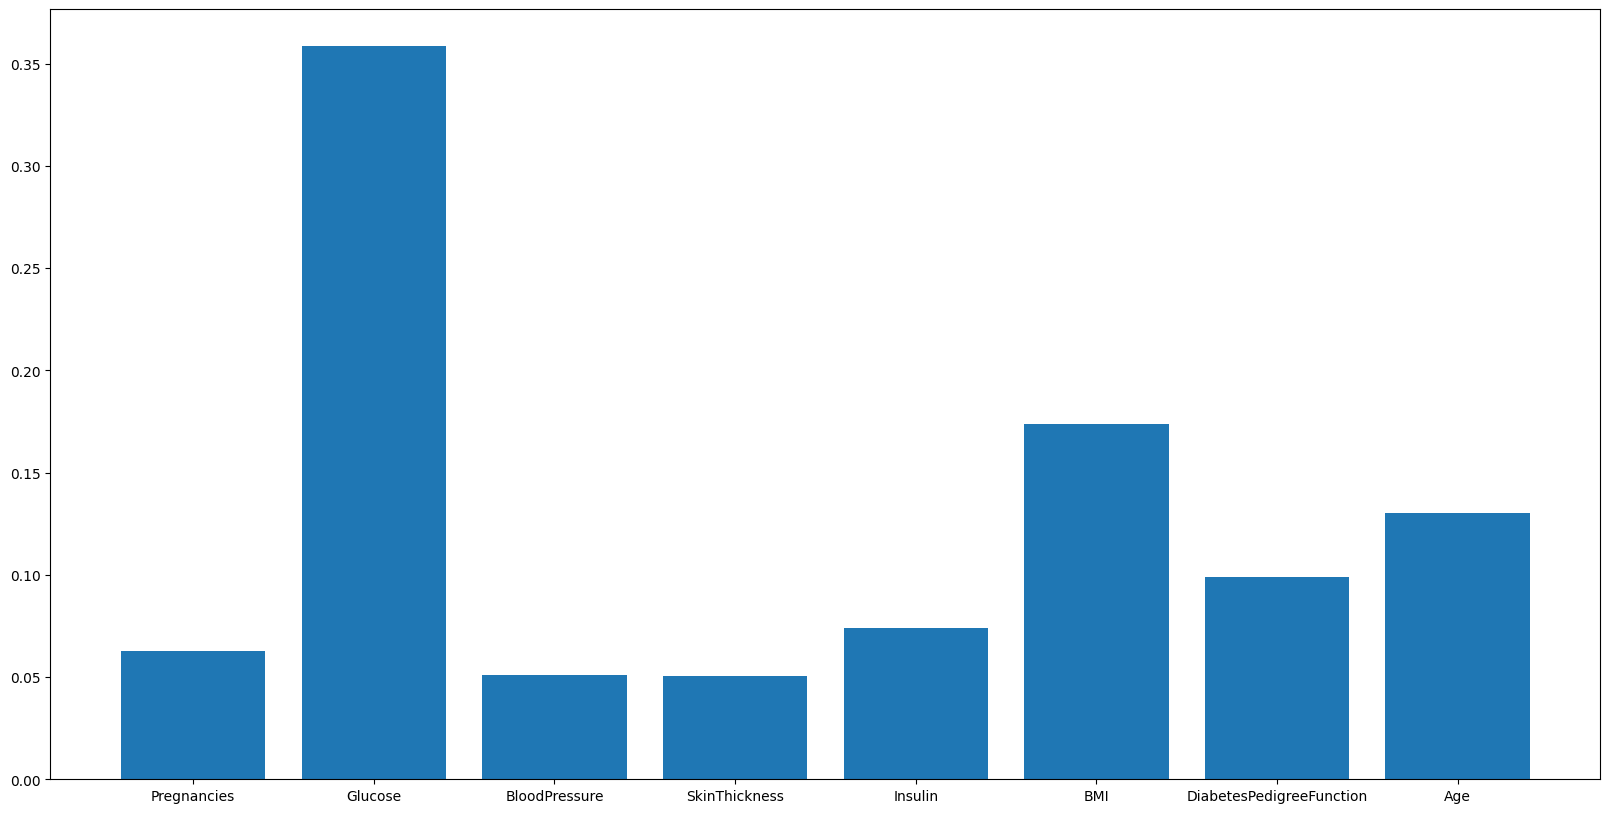

In [39]:
plt.figure(figsize = (20, 10))
fclf = RandomForestClassifier(max_depth = 8, min_samples_leaf = 9, n_estimators = 50)
fclf.fit(X_train, y_train)
plt.bar(X.columns, fclf.feature_importances_)

Жеееееесть, глюкоза наиболее важный фактор в определении сахарного диабета